In [1]:
import sys
import json

torch.manual_seed(0)
sys.path.append('../../')

In [2]:
from utils import *  # ../../utils.py

<h1>2-3. FastText<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prepare-data" data-toc-modified-id="Prepare-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Prepare data</a></span></li><li><span><a href="#Build-the-model" data-toc-modified-id="Build-the-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Build the model</a></span></li><li><span><a href="#Train-the-model" data-toc-modified-id="Train-the-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Train the model</a></span><ul class="toc-item"><li><span><a href="#Training" data-toc-modified-id="Training-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Training</a></span></li></ul></li><li><span><a href="#Results" data-toc-modified-id="Results-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Results</a></span><ul class="toc-item"><li><span><a href="#Embedding-plot" data-toc-modified-id="Embedding-plot-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Embedding plot</a></span></li><li><span><a href="#$n$-most-similar" data-toc-modified-id="$n$-most-similar-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>$n$-most similar</a></span></li><li><span><a href="#cosine-similarity-plot" data-toc-modified-id="cosine-similarity-plot-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>cosine similarity plot</a></span></li></ul></li></ul></div>

## Prepare data

Use subsampling + negative sampling data created in `2-2_skip-gram.ipynb`.

In [3]:
words, vocab, freq, word_to_ix = get_gutenberg_tokens()

In [4]:
with open("./negative_sampling.json") as r:
    data = json.load(r)

In [5]:
x = data["data"]
y = data["label"]

In [6]:
trainset = torch.utils.data.TensorDataset(torch.LongTensor(x),
                                          torch.Tensor(y))
trainset = torch.utils.data.DataLoader(trainset, batch_size=1024, shuffle=True)

* build subword data

`≤`, `≥` are SOF, EOF character, respectively

In [7]:
vocab_ = ["≤"+v+"≥" for v in vocab]
words_ = ["≤"+w+"≥" for w in words]

In [8]:
def ngramify(w, n=3):
    len_w = len(w)
    if len_w <= n:
        return [w]
    else:
        return [w[i:i+n] for i in range(len(w)-n+1)]

def split_to_subword(words_, subword_len=3):
    subwords = []
    for w in words_:
        subwords += ngramify(w, subword_len)
    return subwords

In [9]:
subvocab = list(set(split_to_subword(vocab_)))
sv_to_ix = {k: v for v, k in enumerate(subvocab)}
subvocab[:10]

['ggr', 'nyo', '≤ra', 'ylo', 'opm', 'eez', 'rka', 'uor', '≤s_', '≤20']

In [10]:
# convert word idx to subword idxs
subword_ixs = [list(map(lambda x: sv_to_ix[x], ngramify(v))) for v in vocab_]
wordix_to_subwordix = {wordix: subwordix for wordix, subwordix in enumerate(subword_ixs)}

In [11]:
list(wordix_to_subwordix.items())[:5]

[(0, [6390]),
 (1, [4657, 7329, 1252, 2086]),
 (2, [10, 7046]),
 (3, [416, 3915, 117, 2152]),
 (4, [5423, 3059, 7462, 6391, 6123, 5211])]

In [12]:
SUBVOCAB_SIZE = len(subvocab)
padding = max([len(s) for s in wordix_to_subwordix.values()])

# add padding so that they all have the same length
# this is for tensor operation. (sub-tensor needs to be of same length)
wordix_to_subwordix = {wordix: subwordix + [SUBVOCAB_SIZE] * (padding-len(subwordix)) for wordix, subwordix in enumerate(subword_ixs)}

## Build the model

Similar to skip gram, but with subword information.

$$ y = \sigma\left(\sum_{g\in\mathcal{G}_w} z_g'v_c\right) $$

where $\mathcal{G}_w$ is the subword set of the word $w$. Note that for contexts we use only word-level information.

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [14]:
VOCAB_SIZE = len(vocab)
EMBEDDING_DIM = 100

In [15]:
def get_subword(sample):
    return list(map(lambda w: wordix_to_subwordix[w.item()], sample))

In [24]:
class FastText(nn.Module):
    def __init__(self, subvocab_size, vocab_size, embedding_dim):
        super(FastText, self).__init__()
        
        # adjust Long according to device type
        self.Long = torch.cuda.LongTensor if torch.cuda.is_available() else torch.LongTensor
        
        # embeddings
        self.embedding_z = nn.EmbeddingBag(subvocab_size+1, embedding_dim, mode="sum") # +1 for empty
        self.embedding_z.weight.data[-1] = 0
        self.embedding_v = nn.Embedding(vocab_size, embedding_dim)
        
    def forward(self, x):
        # input should be of shape [batch_size, 1+k, 2]
        x_1, x_2 = x.T
        
        # get subwords
        k = x_1.shape[0]
        x_1_sub = self.Long([get_subword(x_1[i]) for i in range(k)])
        
        # log-likelihood: sum up subword vectors to get word vector
        u = torch.stack([self.embedding_z(subwords) for subwords in x_1_sub])
        v = self.embedding_v(x_2)
        y = (u * v).sum(dim=2).T
        
        return y

## Train the model

LR range test package is useless since a part of the model weight has a constaint (`model.embedding_z.weight[-1] == 0`) which requires the corresponding gradient to be manually fixed in every training step.

### Training

In [25]:
model = FastText(SUBVOCAB_SIZE, VOCAB_SIZE, EMBEDDING_DIM)
model.to(device)

FastText(
  (embedding_z): EmbeddingBag(7487, 100, mode=sum)
  (embedding_v): Embedding(42339, 100)
)

In [26]:
LR = 0.1
MAX_LR = 30.
N_EPOCH = 100

In [27]:
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)
criterion = nn.BCEWithLogitsLoss()

In [28]:
def accuracy(pred):
    pred = (torch.sigmoid(pred) > 0.5).int()
    target = torch.cuda.LongTensor([1, 0, 0])
    correct = ((pred == target).sum(dim=1) == 3)
    return correct.sum() / len(correct)

In [29]:
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=MAX_LR,  # from LR range test plot
    epochs=N_EPOCH, 
    steps_per_epoch=len(trainset)
)

In [30]:
from tqdm import tqdm

losses, accs = [], []
for i in range(1, N_EPOCH+1):
    loss_epoch = 0.
    acc_epoch = 0.
    for batch, target in trainset: #, position=0, leave=False, desc=f"Epoch {i:03}"):
        
        x = batch.to(device)
        target = target.to(device)

        model.zero_grad()
        pred = model(x)
        loss = criterion(pred, target)
        loss.backward()
        
        # zero the gradient of padded embedding_z weight
        # resulting model.embedding_z.weight[-1] should be 0.
        model.embedding_z.weight.grad[-1] = 0.
        
        optimizer.step()
        scheduler.step()
        
        loss_epoch += loss.item()
        acc_epoch += accuracy(pred).item()
    
    losses.append(loss_epoch/len(trainset))
    accs.append(acc_epoch/len(trainset))
    
    if i % 1 == 0:
        print(f"epoch: {i:03}, loss: {loss_epoch/len(trainset): .3f}, acc: {acc_epoch/len(trainset): .4f}")

epoch: 001, loss:  1.714, acc:  0.1685
epoch: 002, loss:  0.907, acc:  0.2125
epoch: 003, loss:  0.784, acc:  0.2399
epoch: 004, loss:  0.737, acc:  0.2585
epoch: 005, loss:  0.717, acc:  0.2720
epoch: 006, loss:  0.709, acc:  0.2804
epoch: 007, loss:  0.707, acc:  0.2861
epoch: 008, loss:  0.707, acc:  0.2900
epoch: 009, loss:  0.706, acc:  0.2928
epoch: 010, loss:  0.707, acc:  0.2946
epoch: 011, loss:  0.708, acc:  0.2966
epoch: 012, loss:  0.710, acc:  0.2974
epoch: 013, loss:  0.714, acc:  0.2979
epoch: 014, loss:  0.718, acc:  0.2981
epoch: 015, loss:  0.726, acc:  0.2974
epoch: 016, loss:  0.733, acc:  0.2970
epoch: 017, loss:  0.740, acc:  0.2962
epoch: 018, loss:  0.750, acc:  0.2952
epoch: 019, loss:  0.759, acc:  0.2949
epoch: 020, loss:  0.770, acc:  0.2933
epoch: 021, loss:  0.778, acc:  0.2924
epoch: 022, loss:  0.788, acc:  0.2913
epoch: 023, loss:  0.798, acc:  0.2903
epoch: 024, loss:  0.805, acc:  0.2896
epoch: 025, loss:  0.812, acc:  0.2885
epoch: 026, loss:  0.817,

In [31]:
# ```python
torch.save(
    model.state_dict(), 
    f"./saved_model/FastText_SGD_lr{LR}+{MAX_LR}+onecycle_momentum0.9_epoch{N_EPOCH}.pth"
)
# ```

## Results

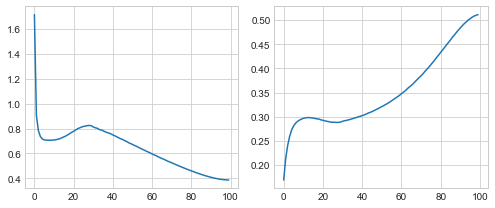

In [32]:
plot_train(losses, accs);

### Embedding plot

In [18]:
model = FastText(SUBVOCAB_SIZE, VOCAB_SIZE, EMBEDDING_DIM)

LR = 0.1
MAX_LR = 30.
N_EPOCH = 100

model.load_state_dict(
    torch.load(
        f"./saved_model/FastText_SGD_lr{LR}+{MAX_LR}+onecycle_momentum0.9_epoch{N_EPOCH}.pth",
    )
)

<All keys matched successfully>

In [33]:
def embedding(word_idx):
    if isinstance(word_idx, int):
        subword_idx = wordix_to_subwordix[word_idx]
        u = (model.embedding_z.weight[subword_idx]).sum(dim=0)
    else:    
        subword_idx = get_subword(word_idx)
        u = [model.embedding_z.weight[subwords].sum(dim=0)\
                 for subwords in subword_idx]
        u = torch.stack(u)
        
    v = model.embedding_v.weight[word_idx]
    return ((u + v) / 2).cpu()

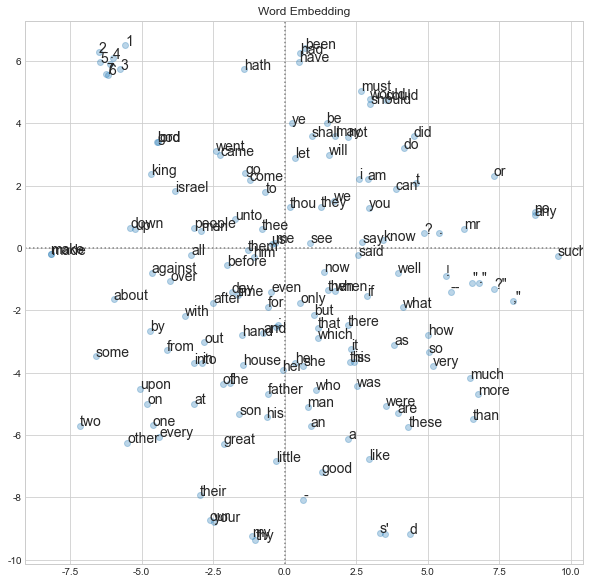

In [34]:
plot_embedding(words, embedding, word_to_ix);

### $n$-most similar

In [35]:
for word in ["angel", "snow", "love", "death"]:
    print(find_similar(word, words, embedding, word_to_ix))

['angels', 'strangely', 'god', 'spake', 'heaven']
['tops', 'crash', 'air', 'grim', 'crossing']
['lovers', 'loved', 'lover', 'loves', 'loveth']
['dead', 'breath', 'bath', 'loveth', 'dealt']


### cosine similarity plot

In [36]:
from sklearn.metrics.pairwise import cosine_similarity

In [43]:
test_word = ["mother", "father", "grandfather", "grandmother",
             "daughter", "sister", "brother",
             "boy", "girl",
             "london", "paris", "europe", "america",
             "life", "live", "death", "dead",
             "have", "had", "has",
             "would", "could", "should", "must",
             "1", "2", "3", "4", "5", "6"]
tt = torch.LongTensor([word_to_ix[w] for w in test_word])
tt = embedding(tt).detach().numpy()

In [44]:
df = pd.DataFrame(cosine_similarity(tt))
df.columns = test_word
df.index = test_word

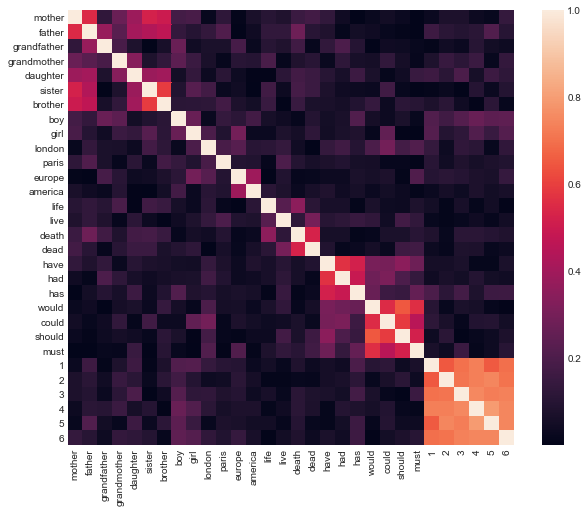

In [45]:
plt.figure(figsize=(10,8))
ax = sns.heatmap(df.abs())